# Filepath Tracking

Filepath tracking allows managing a repository of files using DataJoint. In this scenario, the database is used to track the files using their relative paths as identifiers. DataJoint ensures data integrity and allows working with these files through the DataJoint API. The file repository can be a filesystem or an object storage system such as AWS S3.

Filepath tracking is an experimental feature in version DataJoint 0.12. It is disabled by default and is used by a few groups to validate it more thoroughly before making the feature standard. The feature can be enabled by setting the environment variable `DJ_SUPPORT_FILEPATH_MANAGEMENT` to `"TRUE"`

In [1]:
# Author and date
import datetime, getpass
print(getpass.getuser(), datetime.datetime.today())

dimitri 2019-11-03 23:49:44.066562


In [2]:
# enable the use of filepath tracking for this session. 
# Filepath tracking is disabled by default since the feature is considered experimental.
import os
os.environ['DJ_SUPPORT_FILEPATH_MANAGEMENT'] = "TRUE"  

In [3]:
import datajoint as dj
schema = dj.schema('test_filepath')

Connecting dimitri@localhost:3306


Unlike file attachments, the use of an external store is obligatory in filepath tracking. The files cannot be stored directly in the relational database. 

Let's define an external store called `remote` pointing to the Minio server on the localhost. Here `stage` is the local filepath used for downloading from and uploading to the managed repository located at `location` within the store. The relatives paths are matched between the local `stage` and the store `location`.

In [4]:
## Storage configuration

# set up stores
dj.config['stores'] = {
    'remote': dict(   # store in minio
        stage=os.path.abspath('./stage'),
        protocol='s3',
        endpoint='localhost:9000',
        access_key='datajoint',
        secret_key='datajoint',
        bucket='datajoint-demo',        
        location='')}

## Download some files into ./stage
Let's download some arbitrary files off the web to use as examples. We will use these logo images.
Let's store them in the lookup table `Organization`.

In [5]:
# Step 1: Find a bunch of images on the web. All files must be .png
logos = dict(
    ucsd='https://upload.wikimedia.org/wikipedia/commons/f/f6/UCSD_logo.png',
    datajoint='https://datajoint.io/static/images/DJiotitle.png',
    utah='https://umc.utah.edu/wp-content/uploads/sites/15/2015/01/Ulogo_400p.png',
    bcm='https://upload.wikimedia.org/wikipedia/commons/5/5d/Baylor_College_of_Medicine_Logo.png',
    pydata='https://pydata.org/wp-content/uploads/2018/10/pydata-logo.png',
    python='https://www.python.org/static/community_logos/python-logo-master-v3-TM.png',
    pni='https://vathes.com/2018/05/24/Princeton-Neuroscience-Institute-Partners-with-Vathes-to-Support-the-Adoption-of-DataJoint/PNI%20logo.png')

Let's download these files into the stage folder at the relative path `organization/logos`

In [6]:
# Step 2 download the files into stage path
import requests

local_path = os.path.join(dj.config['stores']['remote']['stage'], 'organizations', 'logos')

os.makedirs(local_path, exist_ok=True)

for name, url in logos.items():
    local_file = os.path.join(local_path, name + '.png')
    with open(local_file, 'wb') as f:
        f.write(requests.get(url).content)
    print('Saved', local_file)

Saved /home/dimitri/dev/dj-python-101/ch1/stage/organizations/logos/ucsd.png
Saved /home/dimitri/dev/dj-python-101/ch1/stage/organizations/logos/datajoint.png
Saved /home/dimitri/dev/dj-python-101/ch1/stage/organizations/logos/utah.png
Saved /home/dimitri/dev/dj-python-101/ch1/stage/organizations/logos/bcm.png
Saved /home/dimitri/dev/dj-python-101/ch1/stage/organizations/logos/pydata.png
Saved /home/dimitri/dev/dj-python-101/ch1/stage/organizations/logos/python.png
Saved /home/dimitri/dev/dj-python-101/ch1/stage/organizations/logos/pni.png


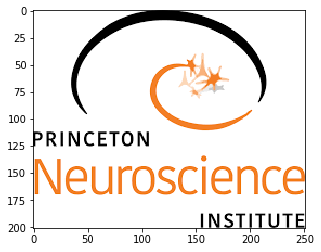

In [7]:
# Verify image

%matplotlib inline
from matplotlib import pyplot as plt
import imageio
plt.imshow(imageio.imread(local_file))

Let's define table `Logo` that to track the files.

In [8]:
@schema
class Logo(dj.Manual):
    definition = """
    # Organization Logos
    
    org : varchar(16)
    ---
    logo_path : filepath@remote
    """

Now when we insert the filepaths from stage, DataJoint will copy them to the store and will keep tracking information such as checksum, size, and date.

In [9]:
# Step 3. Insert the files from stage
for name in logos:
    Logo.insert1(dict(org=name, logo_path=os.path.join(local_path, name)))

DuplicateError: ("Duplicate entry 'ucsd' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

In [10]:
Logo.delete()

About to delete:
`test_filepath`.`logo`: 7 items
Proceed? [yes, No]: yes
Committed.


You may now go to the minio server and verify that the files have been copied at the same relative paths. 

You may insert the same file multiple times but it will only get uploaded once. 

If you try to upload a different file with the same path, an error will result.

### Retrieving tracked filepaths

Now when you fetch the paths from the table, the reverse happens. The files are copied from the remote location into the stage folder.

In [ ]:
# Step 4. delete the local stage completely
import shutil
shutil.rmtree(dj.config['stores']['remote']['stage'])

In [ ]:
# fetch the data again

paths = Logo().fetch('logo_path')

In [ ]:
paths

In [ ]:
paths[-1]

In [ ]:
plt.imshow(imageio.imread(paths[-1]))

In [ ]:
schema.external['remote'].fetch_external_paths()

In [ ]:
schema.external['remote'].unused()

## Remaining issues:

* Re-inserting the same filepath twice with different contents throws and error. This is fixed by deleting the unused external table entries.
* Users may need the option to fetch only the paths or object handles without downloading the files. Fetch option or config?
* Dropping the schema leaves orphaned externals. However, dropping tables works normally.
* Insert(query) with externals has not tested.